<a href="https://colab.research.google.com/github/kfiry77/BiPartiteGraphDeepLearing/blob/main/BipartiteGraphDeepLearningClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training a Neural Networks to identify a Bi-Partite Graphs. 


In [1]:
# installing DGL if needed. 
if 'google.colab' in str(get_ipython()):
  !pip install dgl-cu101   

import dgl
print ("DGL Version:", dgl.__version__)

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import networkx as nx

     |████████████████████████████████| 25.5MB 1.4MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
DGL Version: 0.5.2


### A Graph Adjaceny matrix represenation
The Graph $G=<V,E>$  can be represent with Adjaceny matrix in which $A_{ij} = 1$ , where there is a Edge betwen $E_1$ and $E_2$, otherwise $A_{ij} = 0$. 

### The Graph Data Generators. 

1. Build a random Graph based on [Erdős–Rényi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model), using the code example from [networkx library](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_erdos_renyi.html)

In [2]:
class GenData():
  def Generate(self, vertix_count):
    pass   

  @property
  def name(self):
    return str(type(self)).replace('__main__.GenData', '')

class GenDataRandom(GenData):
  def Generate(self, vertix_count):
    dim = vertix_count
    A = (np.random.rand( dim,  dim) > 0.5) * 1
    # remove unneccasry self node edges. 
    for i in range(0, dim-1): 
      A[i,i] = 0
    return A

class Graph:
  def __init__(self, data_gen, label, vertix_count):
    self.A = data_gen.Generate(vertix_count)
    self.createDglGraph()
    self.label = label

  def createDglGraph(self):
    if isinstance (self.A, nx.Graph):
      self.dgl = dgl.from_networkx(self.A)
    else:
      a = sparse.coo_matrix(self.A) 
      self.dgl = dgl.from_scipy(a)

  def plot(self):
    size = self.dgl.num_nodes()
    fig, ax = plt.subplots()
    nx.draw(self.dgl.to_networkx().to_undirected(), ax=ax, with_labels=True)
    ax.set_title(f'Class: {self.label}')
    plt.show()


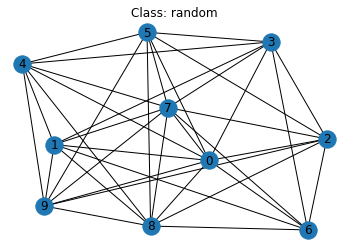

In [3]:
dg = GenDataRandom()
gg = Graph(dg, 'random', 10)
gg.plot()

### Generate various types of Graph with nx Library

In [4]:
class GenDataCycle(GenData):
  def Generate(self, vertix_count):
    return nx.cycle_graph(vertix_count)

class GenDataStar(GenData):
  def Generate(self, vertix_count):    
    return nx.star_graph(vertix_count - 1)

class GenDataWheel(GenData):
  def Generate(self, vertix_count):    
    return nx.wheel_graph(vertix_count)

class GenDataLollipop(GenData):
  def Generate(self, vertix_count):
    path_len = np.random.randint(2, vertix_count // 2)
    return nx.lollipop_graph(m=vertix_count - path_len, n=path_len)

class GenDataClique(GenData):
  def Generate(self, vertix_count):    
    return nx.complete_graph(vertix_count)

class GenDataCircularLadder(GenData):
  def Generate(self, vertix_count):
    return nx.circular_ladder_graph(vertix_count // 2)

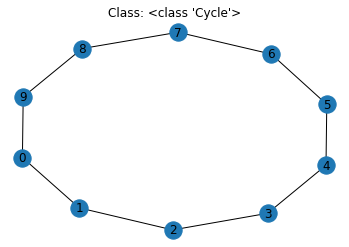

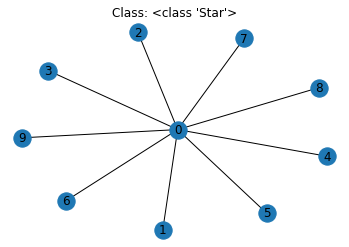

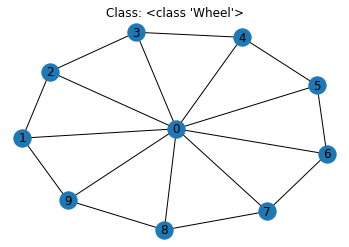

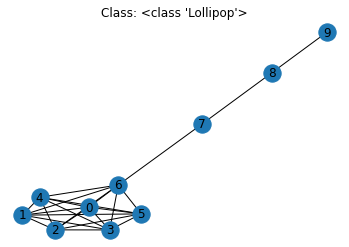

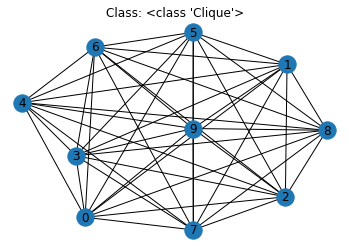

In [5]:
data_gerators = { 'cycle': GenDataCycle(), 'bipartite': GenDataStar(), "Wheel": GenDataWheel(), "Lollipop": GenDataLollipop(), "Complete": GenDataClique() }
for k,v in data_gerators.items():
  g = Graph(v, v.name, 10)
  g.plot()

###Bi-Partite Graphs
a bipartite graph (or bigraph) is a graph whose vertices can be divided into two disjoint and independent sets $U$ and $V$ such that every edge connects a vertex in $U$ to one in $V$. Vertex sets $U$ and $V$ are usually called the parts of the graph.
The adjacency matrix $A$ of a bipartite graph whose two parts have $r$ and $s$ vertices can be written in the form
$
A=\begin{pmatrix}0_{r,r}&B\\B^{T}&0_{s,s} \end{pmatrix} $


In [6]:
class GenDataBiPartite(GenData):
  def Generate(self, vertix_count):    
    dim = int(vertix_count / 2) 
    b = (np.random.rand(dim, dim) > 0.5) * 1
    z = np.zeros((dim,dim), dtype=int) 
    a = np.concatenate((np.concatenate((z, b), axis=0), np.concatenate((b.T,z), axis=0)), axis = 1)
    return a
    
def plotBiPartiteGraph(graph):
  size = graph.dgl.num_nodes()
  fig, ax = plt.subplots()
  arr =  np.concatenate([np.array(['cyan' for x in range(int(size/2))], dtype=np.str), np.array(['yellow' for x in range(int(size/2))], dtype=np.str)])
  pos = dict()
  pos.update( (i, (1, i)) for i in range(int(size/2)) ) # put nodes from X at x=1
  pos.update( (i + int(size/2), (2, i)) for i in range(int(size/2)) ) # put nodes from Y at x=2
  nx.draw(graph.dgl.to_networkx().to_undirected(), pos=pos, ax=ax, node_color=arr, with_labels=True)
  ax.set_title(f'Class: {graph.label}')
  plt.show()

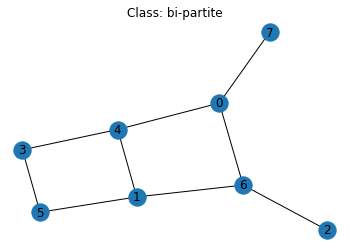

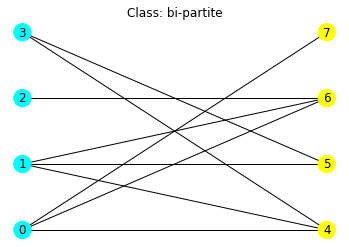

In [7]:
dg = GenDataBiPartite()
gg = Graph(dg, 'bi-partite', 8)
gg.plot()
plotBiPartiteGraph(gg)

## DGL

Notes: 
1. We would like to check whether the GCN can idetify a bipartite graph
1. As a traing data we need to create a _labeled_ dataset that contains
  1. bi-partite graphs
  1. random graphs, 
  1. Almost bi-partite graphs, by taking a bi-partite graph and poluting it with edges between nodes in the same sets.  
1. There are some kinds of generators from networkX. It is described library : [NetworkX-bipartite](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.bipartite.html?highlight=bipartite)

## Graph Classification 
Based on [Graph Classification Tutorial](https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html)

# DataSet

DGL come with several out of the box graphs datasets. one off them is the [MiniGCDDataset](https://docs.dgl.ai/en/0.4.x/api/python/data.html#mini-graph-classification-dataset).

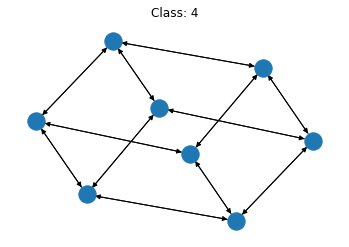

num of classes: 8


In [11]:
from dgl.data import MiniGCDataset

# A dataset with 80 samples, each graph is of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
# Example to a graphs from the dataset. 
graph, label = dataset[40]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()
print("num of classes:",  dataset.num_classes)

## Dataset Graph Generator

The Given Demostration were using MiniGCDataset, Our goal is to create a dataset that will expose the same interface as the MiniGCDataset exposes, The `RandomGraphSetGenrator` Class will generate `num_graphs` Graphs, and spread them evenlly acording to the given genrators. e.g : if `num_graphs = 10` and `len(data_generators) == 2` then there will be 2 types of generated graphs. 

Parameters:	
- num_graphs (int) – Number of graphs in this dataset.
- min_num_v (int) – Minimum number of nodes for graphs
- max_num_v (int) – Maximum number of nodes for graphs
- data_generators - A dictionary of Implemntation of the class DataGenerator. 

In [12]:
"""A mini synthetic dataset for graph classification benchmark."""
class RandomGraphSetGenrator(object):
  """The dataset class.
  The datset created is acording to the given Graph Generator. 
  .. note::
      This dataset class is compatible with pytorch's :class:`Dataset` class.
  Parameters
  ----------
  num_graphs: int
      Number of graphs in this dataset.
  min_num_v: int
      Minimum number of nodes for graphs
  max_num_v: int
      Maximum number of nodes for graphs
  """
  def __init__(self, num_graphs, min_num_v, max_num_v, data_generators):
    super(RandomGraphSetGenrator, self).__init__()
    self.num_graphs = num_graphs
    self.min_num_v = min_num_v
    self.max_num_v = max_num_v
    self.graphs = []
    self.labels = []
    self.data_generators = data_generators
    self._generate()

  def __len__(self):
        """Return the number of graphs in the dataset."""
        return len(self.graphs)

  def __getitem__(self, idx):
    """Get the i^th sample and returns (dgl.DGLGraph, int)
        The graph and its label.
    """
    return self.graphs[idx], self.labels[idx]

  @property
  def num_classes(self):
    """Number of classes."""
    return len(self.data_generators)

  def _generate(self):
      i = 0
      for k,v in self.data_generators.items():
        for _ in range(self.num_graphs // self.num_classes):
          num_v = np.random.randint(self.min_num_v, self.max_num_v)
          g = Graph(v, k, num_v).dgl
          # add self edges
          nodes = g.nodes()
          g.add_edges(nodes, nodes)
          self.graphs.append(g)
          self.labels.append(i)
        i = i + 1

## The classifier Neural network. 

In [13]:
from dgl.nn.pytorch import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

## Train and Classify

In [14]:
import torch.optim as optim
from torch.utils.data import DataLoader

class ModelTrainer:
  # Use PyTorch's DataLoader and the collate function defined before.
  def __init__(self, trainset):
    self.data_loader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate)
    self.model = Classifier(1, 256, trainset.num_classes)
    self.loss_func = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)    

  def trainModel(self, epoch_count):
    self.model.train()
    epoch_losses = []
    for epoch in range(epoch_count):
      epoch_loss = 0
      for iter, (bg, label) in enumerate(self.data_loader):
        prediction = self.model(bg)
        loss = self.loss_func(prediction, label)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        epoch_loss += loss.detach().item()
      epoch_loss /= (iter + 1)
      if epoch % 5 == 0:
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
      epoch_losses.append(epoch_loss)
      self.epoch_losses = epoch_losses
  def plot_loses(self):
      plt.title('cross entropy averaged over minibatches')
      plt.plot(self.epoch_losses)
      plt.show()

  def Evaluate(self, testset):
    self.model.eval()
    # Convert a list of tuples to two lists
    test_X, test_Y = map(list, zip(*testset))
    test_bg = dgl.batch(test_X)
    test_Y = torch.tensor(test_Y).float().view(-1, 1)
    probs_Y = torch.softmax(self.model(test_bg), 1)
    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
      (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
    print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
      (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))      

Epoch 0, loss 2.0088
Epoch 5, loss 1.9230
Epoch 10, loss 1.7754
Epoch 15, loss 1.4658
Epoch 20, loss 1.1862
Epoch 25, loss 1.0311
Epoch 30, loss 0.9154
Epoch 35, loss 0.8526
Epoch 40, loss 0.8088
Epoch 45, loss 0.7864
Epoch 50, loss 0.7755
Epoch 55, loss 0.7406
Epoch 60, loss 0.7439
Epoch 65, loss 0.6962
Epoch 70, loss 0.7071
Epoch 75, loss 0.6808


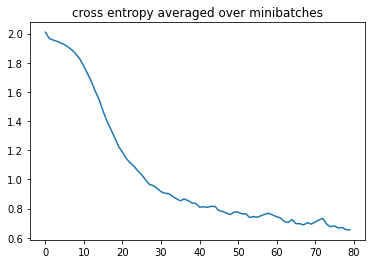

Accuracy of sampled predictions on the test set: 61.2500%
Accuracy of argmax predictions on the test set: 70.000000%


In [15]:
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

trainer = ModelTrainer(trainset)
trainer.trainModel(80)
trainer.plot_loses()
trainer.Evaluate(testset)

Epoch 0, loss 1.4951
Epoch 5, loss 1.3983
Epoch 10, loss 1.1792
Epoch 15, loss 0.8738
Epoch 20, loss 0.6349
Epoch 25, loss 0.5522
Epoch 30, loss 0.4609
Epoch 35, loss 0.4797
Epoch 40, loss 0.3697
Epoch 45, loss 0.3197
Epoch 50, loss 0.2942
Epoch 55, loss 0.2521
Epoch 60, loss 0.2527
Epoch 65, loss 0.2036
Epoch 70, loss 0.1988
Epoch 75, loss 0.1812


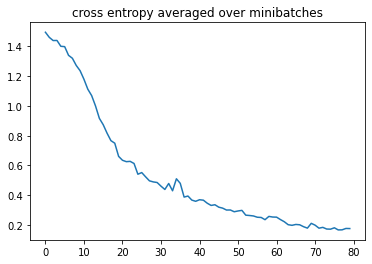

Accuracy of sampled predictions on the test set: 88.0000%
Accuracy of argmax predictions on the test set: 92.000000%


In [16]:
# check our new Graphs Generator. 

data_gerators = { 'cycle': GenDataCycle(), 'star': GenDataStar(), "Wheel": GenDataWheel(), "Lollipop": GenDataLollipop(), "Complete": GenDataClique() }

trainset = RandomGraphSetGenrator(300, 10,30, data_gerators)
testset = RandomGraphSetGenrator(50, 10,30, data_gerators)

trainer = ModelTrainer(trainset)
trainer.trainModel(80)
trainer.plot_loses()
trainer.Evaluate(testset)

Epoch 0, loss 0.6731
Epoch 5, loss 0.6131
Epoch 10, loss 0.4913
Epoch 15, loss 0.4079
Epoch 20, loss 0.4138
Epoch 25, loss 0.4136
Epoch 30, loss 0.3852
Epoch 35, loss 0.3732
Epoch 40, loss 0.3850
Epoch 45, loss 0.3921
Epoch 50, loss 0.3974
Epoch 55, loss 0.3781
Epoch 60, loss 0.4013
Epoch 65, loss 0.3649
Epoch 70, loss 0.3777
Epoch 75, loss 0.3489


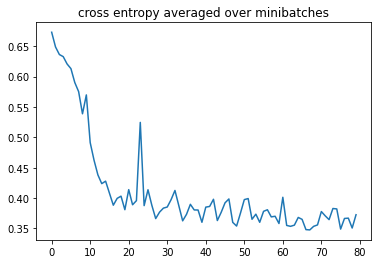

Accuracy of sampled predictions on the test set: 82.0000%
Accuracy of argmax predictions on the test set: 78.000000%


In [18]:
data_gerators = { 'random': GenDataRandom(), 'bipartite': GenDataBiPartite() }

trainset = RandomGraphSetGenrator(300, 10,30, data_gerators)
testset = RandomGraphSetGenrator(50, 10,30, data_gerators)

trainer = ModelTrainer(trainset)
trainer.trainModel(80)
trainer.plot_loses()
trainer.Evaluate(testset)